# Testing Grounds - Fit Loop
Creating a library that helps with the pytorch looping.

## Testing

In [1]:
import torch
from torch import optim, nn
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torchvision.datasets import FakeData
from torchvision.transforms import ToTensor
from fitloop import FitLoop

device = torch.device('cpu')

### Stage Functions

#### Batch Steps

In [2]:
def common_step(state):
#     print(f"{state.phase}_step, bn: {state.batch_num} en: {state.epoch_num}, ",end="")
    X, y = state.batch
    y_ = state.model(X)
    loss = state.loss_function(y_,y)
#     print("loss",loss.item())
    r_loss = loss.item() * state.batch_size
    r_corr = (y_.argmax(dim=1) == y).sum().item()
    return loss, r_loss, r_corr

def train_step(state):
    loss, r_loss, r_corr = common_step(state)
    loss.backward()
    state.optimizer.step()
    return {'r_loss':r_loss,'r_corr':r_corr}

def valid_step(state):
    loss, r_loss, r_corr = common_step(state)
    return {'r_loss':r_loss,'r_corr':r_corr}

def test_step(state):
    loss, r_loss, r_corr = common_step(state)
    return {'r_loss':r_loss,'r_corr':r_corr}

#### Epoch Start Step

In [3]:
def common_epoch_start(state):
#     print(f"\n{state.phase}_epoch_start, # {state.epoch_num}")
    return {'dummy':'dict'}
    
def train_epoch_start(state):
    return common_epoch_start(state)

def valid_epoch_start(state):
    return common_epoch_start(state)

def test_epoch_start(state):
    return common_epoch_start(state)

#### Epoch End Steps

In [4]:
def common_epoch_end(state):
#     print(f"{state.phase}_epoch_end, # {state.epoch_num}")
    r_loss = state['r_loss']
    r_corr = state['r_corr']
    
#     print('r_loss len',len(r_loss))
#     print('r_corr len',len(r_corr))
    
    e_loss = r_loss.sum()/state.size
    e_accu = r_corr.sum()/state.size
    
#     print('loss',e_loss)
#     print('accu',e_accu)
    
    return {'loss':e_loss, 'accu':e_accu}
    
def train_epoch_end(state):
    return common_epoch_end(state)

def valid_epoch_end(state):
    return common_epoch_end(state)

def test_epoch_end(state):
    return common_epoch_end(state)

### FitLoop - Usage

#### Setup

In [2]:
"""
Basic setup with FakeData for testing.
"""

def get_dl(batch_size=4, sz=[100,20,30]):
    sets = ['train','valid','test']
    TR, VA, TE = sets
    class_names = ['a','b','c','d']
    num_classes = 4

    sz = {s:z for s, z in zip(sets,sz)} # a multiple of batch size
    ds = {s:FakeData(size=sz[s], transform=ToTensor(), num_classes=num_classes) for s in sets}
    dl = {s:DataLoader(ds[s],batch_size=batch_size) for s in ds}
    return dl

TR, VA, TE = ['train','valid','test']

num_classes = 4
model = resnet18()
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

    
dummy = nn.Sequential(
    nn.Conv2d(3,1,3,10),
    nn.Flatten(),
    nn.Linear(529,4)
)

model = dummy

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# ----------------------------------------------

def configure_optimizer(self):
    parameters = self.model.parameters()
    self.optimizer.param_groups.clear()
    self.optimizer.add_param_group({'params': parameters})
    
dl = get_dl(batch_size=5,sz=[52,12,23])
fl_dict = {
    "model": model,
    "optimizer": optimizer,
    "loss_function": loss_function,
    "train_dl":dl[TR],
    "valid_dl":dl[VA],
    "test_dl":dl[TE],
#     "train_step":train_step,
#     "valid_step":valid_step,
#     "test_step":test_step,
#     "train_epoch_start":train_epoch_start,
#     "valid_epoch_start":valid_epoch_start,
#     "test_epoch_start":test_epoch_start,
#     "train_epoch_end":train_epoch_end,
#     "valid_epoch_end":valid_epoch_end,
#     "test_epoch_end":test_epoch_end,
#     "criteria": "accu"
    "configure_optimizer":configure_optimizer,
}

trainer = FitLoop(**fl_dict)

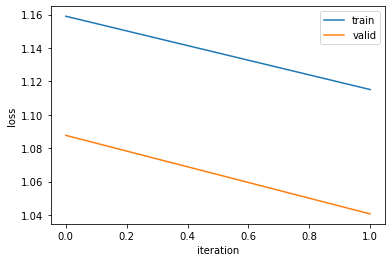

In [13]:
trainer.plot('loss')

In [5]:
trainer.fit(epochs=6)

[1/6] - train :: accuracy: 0.6731 | loss: 1.1612 
        valid :: accuracy: 0.8333 | loss: 1.0944 
        epoch time: 00 s 393 ms


[2/6] - train :: accuracy: 0.7308 | loss: 1.1227 
        valid :: accuracy: 0.8333 | loss: 1.0519 
        epoch time: 00 s 326 ms


[3/6] - train :: accuracy: 0.7692 | loss: 1.0816 
        valid :: accuracy: 0.8333 | loss: 1.0075 
        epoch time: 00 s 305 ms


[4/6] - train :: accuracy: 0.8269 | loss: 1.0377 
        valid :: accuracy: 0.8333 | loss: 0.9599 
        epoch time: 00 s 311 ms


[5/6] - train :: accuracy: 0.8846 | loss: 0.9909 
        valid :: accuracy: 0.8333 | loss: 0.9092 
        epoch time: 00 s 326 ms


[6/6] - train :: accuracy: 0.9231 | loss: 0.9413 
        valid :: accuracy: 0.8333 | loss: 0.8560 
        epoch time: 00 s 336 ms

-----
total time: 02 s 050 ms
best score: 0.8333


In [7]:
trainer.M.phases

['train', 'valid']

#### Execution

In [8]:
# trainer.fit(epochs=3, train_dl=dl[TR], valid_dl=dl[VA])
trainer.fit(epochs=2)

[1/2] - train :: accuracy: 0.6923 | loss: 1.1590 
        valid :: accuracy: 0.8333 | loss: 1.0877 
        epoch time: 00 s 359 ms


[2/2] - train :: accuracy: 0.7308 | loss: 1.1151 
        valid :: accuracy: 0.8333 | loss: 1.0407 
        epoch time: 00 s 299 ms

-----
total time: 00 s 704 ms
best score: 0.8333


In [14]:
trainer.test()

test :: accuracy: 0.7826 | loss: 1.1562 

-----
total time: 00 s 149 ms


In [15]:
# trainer.run_sanity_check(use_test_dl=True,steps=None, train_dl=dl[TR], valid_dl=dl[VA], test_dl=dl[TE])
trainer.run_sanity_check(use_test_dl=True,steps=None)

RUNNING SANITY CHECK: TRAIN LOOP - 1 EPOCH(s), None STEP(s)


[1/1] - train :: accuracy: 0.6731 | loss: 1.1602 
        valid :: accuracy: 0.8333 | loss: 1.0890 
        epoch time: 00 s 350 ms

-----
total time: 00 s 385 ms
best score: 0.8333

RUNNING SANITY CHECK: TEST LOOP - None STEP(s)


test :: accuracy: 0.7826 | loss: 1.1562 

-----
total time: 00 s 150 ms


In [16]:
# _ = trainer.run_profiler(epochs=2, steps=None, train_dl=dl[TR], valid_dl=dl[VA], test_dl=dl[TE])
_ = trainer.run_profiler()

RUNNING PROFILER: TRAIN LOOP 1 EPOCH(s)
  train dl :: batches:   11 batch_size:    5 last_batch:    2 dataset_size:     52
  valid dl :: batches:    3 batch_size:    5 last_batch:    2 dataset_size:     12




RUNNING PROFILER: TEST LOOP 
  test  dl :: batches:    5 batch_size:    5 last_batch:    3 dataset_size:     23




AVERAGE TIMES
1. initialize:       00 s 001 ms 788 us
2. train
  1. epoch_start:    00 s 338 ms 999 us
  2. step:           00 s 001 ms 758 us
  3. batch_inner:    00 s 002 ms 048 us
  4. batch_loop:     00 s 230 ms 417 us
  5. epoch_end:      00 s 000 ms 134 us
  6. phase_inner:    00 s 230 ms 646 us
3. valid
  1. epoch_start:    00 s 632 ms 000 us
  2. step:           00 s 000 ms 450 us
  3. batch_inner:    00 s 000 ms 535 us
  4. batch_loop:     00 s 038 ms 240 us
  5. epoch_end:      00 s 842 ms 099 us
  6. phase_inner:    00 s 038 ms 351 us
4. phase loop:       00 s 300 ms 097 us
5. epoch
  1. inner:          00 s 301 ms 738 us
  2. loop:           00 s 344 ms 071 us
  3. inner_t:        00 s 210 ms 936 us
  4. loop_t:         00 s 211 ms 320 us
6. restore model:    00 s 000 ms 536 us
7. total:            00 s 346 ms 444 us
8. initialize_t:     00 s 000 ms 874 us
9. test
  1. epoch_start_t:  00 s 057 ms 000 us
  2. step_t:         00 s 000 ms 854 us
  3. batch_inner_t:  00 s 002 

## TODO

### FitLoop

- Bare minimum to structure and push to Pypi:
    - Test on console.
    - Metrics plot
    - Onchanging model update parameters appropriately
    - ✅Metrics Viz
    - ✅FitLoopDefaults (really simple ones)
    - ✅All stage functions except for `train_step` should be optional that's the only one that is required for training the model, rest all are for metric keeping.
    - ✅Make it easy to train, validate, test with some other DataLoader that is not attached to the object.
    - ✅Fix No Continue
    - ✅Metrics
- `FitLoop.save(path:str)` to save the model and training state somehow even the FitLoop state.
- `FitLoop.load(path:str)` to load the FitLoop state from given path.
- ✅`FitLoop.profiler()` mode to capture all stage timings and maybe even CPU, GPU, RAM usage to check for bottlenecks and usage spikes, to be used with timed_test.
- ✅if `FitLoop.fit(define_all:bool=False)` the zero_grad and the context manager are not auto set.
- ✅should keep track of epochs that have been completed
- ✅epoch_number can be reset 
- ✅`FitLoop.metrics.set_name.loop_stage['metric_name']` to access the metric
- ✅`FitLoop.store_pretrained:bool` arg to store the pretrained weights before training
    if path then store at given path else store in memory.
- ✅`FitLoop.reset(reset_model:bool)` to clear metrics, epoch_num and to reset the model, to pretrained state
    will load the weight from passed path else from memory.
- ✅`FitLoop.fit(continue_loop:int=0)` ask after `int` whether to continue training or to end.
- ✅`FitLoop.fit(profiler:bool=False)` mode to capture all stage timings and maybe even CPU, GPU, RAM usage to check for bottlenecks and usage spikes, to be used with timed_test.
- ✅Functionality to view the metrics.
- ✅Model score should be a loop instance so that the best model may not be erased.
- ✅Time keeping/ metric keeping:
    - General
        - ✅Metrics returned in the batch step
        - ✅Metrics returned in the end step
        - ✅Progress bar for epoch
        - ✅Progress bar for batch that disappears after complete
        - ✅Epoch timing (for both phases when training)
        - ✅Total timing 
        
    - Profiler Mode:
        - ✅Individual Stage Timings
        
- ✅Check with uneven batchsizes.
 
#### Later Incremental Addons
- Profiler Mode:
    - Use an actual profiler ie: `cProfile`
    - Individual Stage CPU Usage
    - Individual Stage GPU Usage
    - Individual Stage RAM Usage
- Use better logging (maybe) `warnings` and `logging`

### ✅FitLoopDefaults

- ✅Basic functions for
    - ✅train_step
    - ✅valid_step
    - ✅test_step
- ✅Basic funtions for 
    - ✅train_epoch_end
    - ✅valid_epoch_end
    - ✅test_epoch_end

*FitLoopDefaults shouldn't be a class, it should be a module.*

### ✅Metrics/MetricsAggregator

```python
# Value access
Fitloop.metrics.train['loss']                 # ✅returns all losses from epoch end
Fitloop.metrics.train.epoch_end['loss']       # ✅returns all losses from epoch end
Fitloop.metrics.train.epoch_start['loss']     # ✅returns all losses from epoch start
Fitloop.metrics.train.batch_step['loss']      # ✅returns all losses from batch step
 
Fitloop.metrics.train['loss'][0]              # ✅returns losses for run 0 from epoch end
Fitloop.metrics.valid.batch_step['accu'][3]   # ✅returns all validation accuracies for batch step from run 3
 
# Value visualization 
Fitloop.metrics.plot()                        # ✅plots validation criteria against training criteria (eg accuracy)
                                              # ✅if criteria not available, then first key from rdict.
Fitloop.metrics.train.plot()                  # ✅if loss then loss else, plots first value from rdict
Fitloop.metrics.train.plot('loss')            # ✅plots loss 
```
- ✅metrics can be cleared

### ✅LoopState 

- ✅should cast the batch to device before passing it using `state.batch()`
- ✅should get the batch num `state.batch_num` and epoch num `state.epoch_num`
- ✅the model, optimizer, loss_function, lr_scheduler should be available
    `state.model`, `state.optimizer`, `state.loss_function`, `state.lr_scheduler`
- ✅should return the batch metrics as float tensors using square bracket indexing
    `state['loss']` 
    - every step function hook receives the LoopState object.
- ✅The loop state object should have a copy of all the values returned from the function hook
- ✅example the below returned dict values should be avialable in the LoopState object

```python
def train_step(state):
    X,y = state() # should device cast automatically
    y_ = state.model(X)
    loss = state.loss_function(y_, y)
    
    state.optimizer.zero_grad()
    loss.backward()
    state.optimizer.step()
    state.lr_scheduler.step() 
    
    loss = loss.item()
    batch_loss = loss * y.size()
    batch_corr = (y_.argmax(dim=0) == y).sum().float().item()
    
    return {'loss':loss,'batch_loss':batch_loss:'batch_corr'}
```
- ✅The LoopState object should be cleared of the above values at the start 
  of the next epoch.
- ✅The returned values should be available through the FitLoop object
  Eg: `FitLoop.metrics.train.batch['loss']`
- ✅The (above statement) returned value should be optionally available by setting the flag 
  `track_batch_metrics`

```python
def train_epoch_end(state):
    loss = state['loss']
    batch_loss = state['batch_loss']
    batch_corr = state['batch_corr']
    
    size = state.size
    
    epoch_loss = batch_loss.sum().item()/size
    epoch_accu = batch_corr.sum().item()/size
    
    return {"loss":epoch_loss,"accu":epoch_accu}
```

- ✅The returned values should be available through the FitLoop object
  Eg: `FitLoop.metrics.train.epoch['loss']`
- ✅For each phase a different LoopState obect is maintained.

